# Forcing Profile Comparison

In [9]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

site = "site23"
# hadgem 
hadgem = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = site)
# era5 forcing
era5 = xr.open_dataset("era5_monthly_forcing_1.nc", group = site)

In [10]:
t= ["ta", "ua", "va", "hus", "wap", "tntva", "tnhusva", "tntha", "tnhusha"]
# era5.z.sel(date = 20080701).values
# hadgem.zg.mean(dim = "time").plot()
# era5

# filter to below 10km 
# era5 = era5.where(era5.z < 10000, drop = True)
# era5
# era5.pressure_level > 264
# era5.z.values / 9.81
# sum(era5.pressure_level > 264)
# era5.z
hadgem_10k = hadgem.where(hadgem.zg < 10000, drop = True)
era5_10k = era5.where(era5.z < 10000, drop = True)

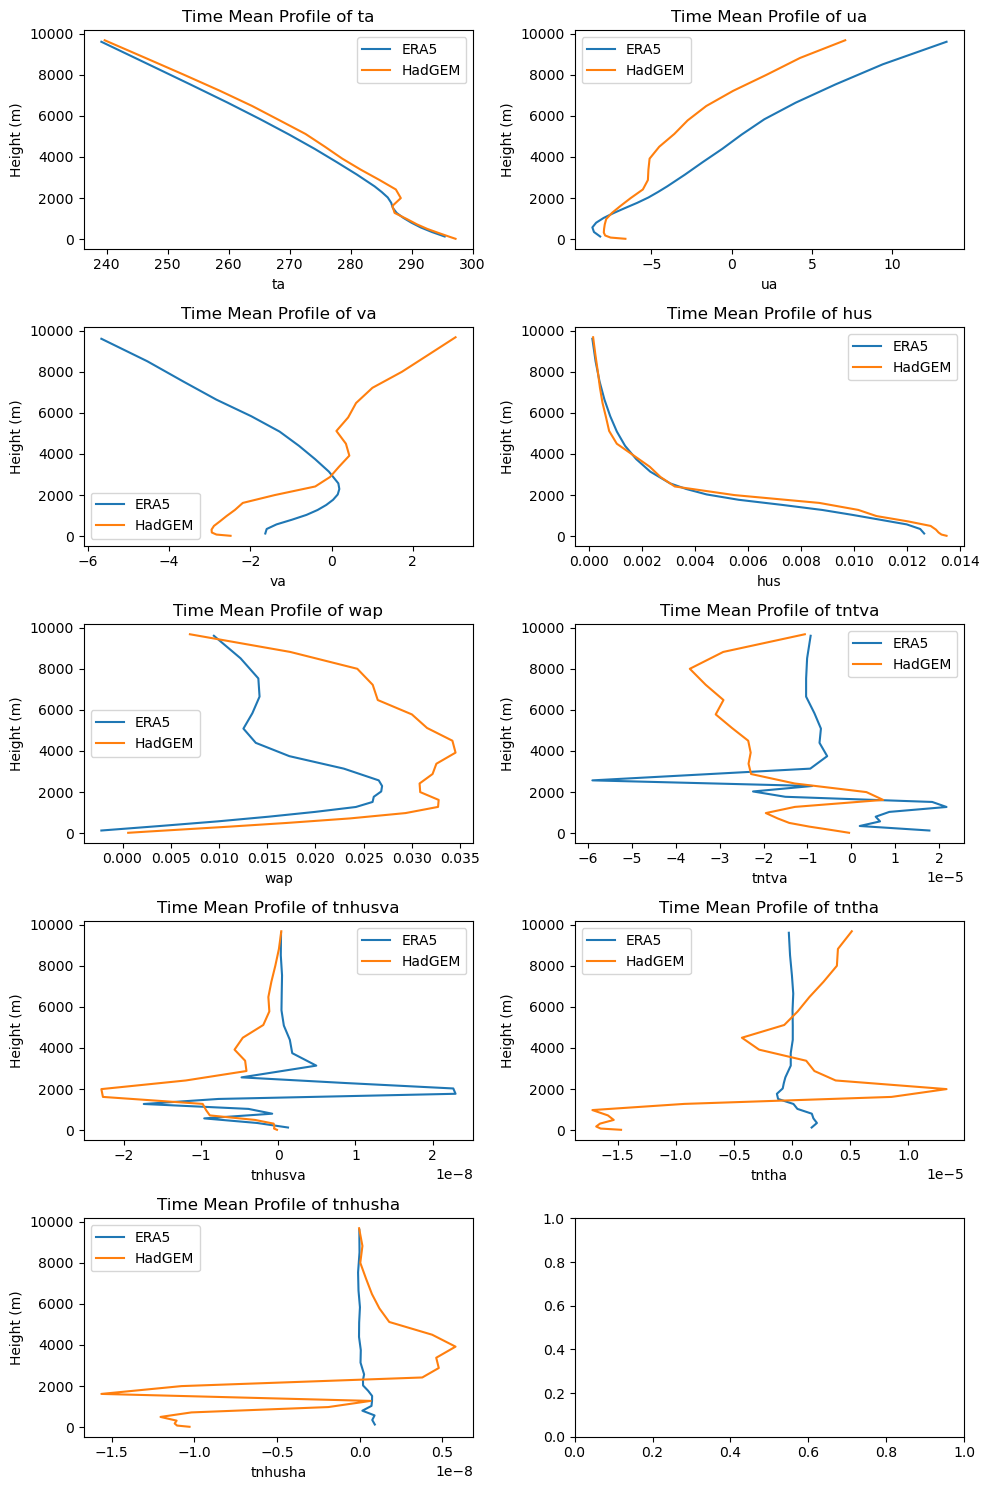

In [11]:
# plot time_mean profiles for hadgem and era5
fig, axes = plt.subplots(nrows=int(np.ceil(len(t)/2)), ncols=2, figsize=(10, 5 * 3))
axes = axes.flatten()
for ax, var in zip(axes, t):
    era5_mean = era5_10k[var]#.sel(date = 20080701)
    hadgem_mean = hadgem_10k[var].mean(dim='time')
    # if var in ["tntva", "tnhusva"]:
    #     ax.plot(era5_mean, era5_10k.zg.sel(date = 20080701), label='ERA5')
    # else:
    ax.plot(era5_mean, era5_10k.z, label='ERA5') #.sel(date = 20080701)
    ax.plot(hadgem_mean, hadgem_10k["lev"], label='HadGEM')

    
    ax.set_title(f'Time Mean Profile of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Height (m)')
    ax.legend()

plt.tight_layout()
plt.show()

In [7]:
import xarray as xr
nh_surface_data = xr.open_dataset("~/Downloads/era5/monthly/NH_monthly_surface.nc")
nh_surface_data.where(nh_surface_data["date"] ==20080701, drop = True).tisr / 86400 # because ERA5 is weird

<xarray.DataArray 'tisr' (date: 1, latitude: 93, longitude: 113)> Size: 84kB
array([[[467.66222222, 467.66222222, 467.66222222, ..., 467.65037037,
         467.65037037, 467.65037037],
        [467.72148148, 467.72148148, 467.72148148, ..., 467.70962963,
         467.70962963, 467.70962963],
        [467.76888889, 467.76888889, 467.76888889, ..., 467.75703704,
         467.75703704, 467.75703704],
        ...,
        [444.8       , 444.8       , 444.8       , ..., 444.83555556,
         444.83555556, 444.83555556],
        [444.21925926, 444.21925926, 444.21925926, ..., 444.25481481,
         444.25481481, 444.25481481],
        [443.62666667, 443.62666667, 443.62666667, ..., 443.66222222,
         443.66222222, 443.66222222]]])
Coordinates:
    number     int64 8B 0
  * date       (date) int64 8B 20080701
  * latitude   (latitude) float64 744B 39.0 38.75 38.5 38.25 ... 16.5 16.25 16.0
  * longitude  (longitude) float64 904B -150.0 -149.8 -149.5 ... -122.2 -122.0
    expver     (date) <U4 16B '0001'

In [21]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt

# extract locations and pick sites
geo = xr.open_dataset("coszen_data.nc")
minsite = 2
maxsite = 23
included_sites = geo.where((geo["site"] <=maxsite) & (geo["site"] >= minsite) & (geo["site"] != 16), drop = True)
lats = included_sites.lat
lons = included_sites.lon
sites = included_sites.site
coszen = included_sites.coszen

# northern hemisphere era5 data 
nh_column_data = xr.open_dataset("~/Downloads/era5/monthly/NH_monthly_PL.nc")
nh_surface_data = xr.open_dataset("~/Downloads/era5/monthly/NH_monthly_surface.nc")


# southern hemisphere era5 data
sh_column_data = xr.open_dataset("~/Downloads/era5/monthly/SH_monthly_PL.nc")
sh_surface_data = xr.open_dataset("~/Downloads/era5/monthly/SH_monthly_surface.nc")



In [22]:
geo

<xarray.Dataset> Size: 7kB
Dimensions:  (site: 119, date: 4)
Coordinates:
  * site     (site) int64 952B 1 2 3 4 5 6 7 8 ... 113 114 115 116 117 118 119
  * date     (date) int64 32B 20080101 20080401 20080701 20081001
Data variables:
    lat      (site) float64 952B ...
    lon      (site) float64 952B ...
    coszen   (date, site) float64 4kB ...

In [23]:
tisr_resolution = 86400
def get_horizontal_tendencies(lon, lat, column_ds):
    """Computes horizontal tendencies for temperature and specific humidity at a given location.
    Args:
    lon: site longitude
    lat: site latitude
    column_ds: xarray dataset containing ERA5 data at pressure levels 
    """
    west = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon - .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    east = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon + .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    north = column_ds.where((column_ds.latitude == lat + .25) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    south = column_ds.where((column_ds.latitude == lat - .25) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    center = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    
    # convert to radians for gradient calculation 
    rearth = 6378e3
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon - 360)
    coslat = np.cos(lat)
    dx = 2 * np.pi * rearth * coslat / 360 # per degree longitude
    dy = 2 * np.pi * rearth / 360 # per degree latitude

    # compute advective tendencies
    # Temperature
    tntha = center.u * (west.t - 2 * center.t + east.t) / (2 * dx / 4) + center.v * (south.t - 2 * center.t + north.t) / (2 * dy / 4)
    # specific humidity
    tnhusha = center.u * (west.q - 2 * center.q + east.q) / (2 * dx / 4) + center.v * (south.q - 2 * center.q + north.q) / (2 * dy / 4)

    return tntha, tnhusha

#get_tendencies(lon, lat, col)[0]

def get_vertical_tendencies(column_ds, var, vertvar = "wa"):
    """
    Calculate the temperature and specific humidity vertical tendencies as a function of levels
    using vertical advection.
    """
    tntva_trend = []
    
    # Loop through each pressure level
    num_levels = column_ds[vertvar].shape[1]  # Number of vertical levels

    for i in range(num_levels):
        if i == 0:  # Bottom level (forward difference)
            tntva = column_ds[vertvar][:, i] * (column_ds[var][:, i+1] - column_ds[var][:, i]) / (column_ds.z[:, i+1] - column_ds.z[:, i])
        
        elif i == num_levels - 1:  # Top level (backward difference)
            tntva = column_ds[vertvar][:, i] * (column_ds[var][:, i] - column_ds[var][:, i-1]) / (column_ds.z[:, i] - column_ds.z[:, i-1])
        
        else:  # Middle levels (surface_dsed difference)
            tntva = column_ds[vertvar][:, i] * (column_ds[var][:, i+1] - 2 * column_ds[var][:, i] +  column_ds[var][:, i-1]) / ((column_ds.z[:, i+1] - column_ds.z[:, i-1]))

        tntva = tntva.assign_coords(pressure_level=column_ds.pressure_level[i])

        # Append the result to the trend list
        tntva_trend.append(tntva)
    
    # Convert the trend list to an xarray object, correctly indexed by pressure levels
    tntva_trend = xr.concat(tntva_trend, dim="pressure_level")
    tntva_trend = tntva_trend.assign_coords(pressure_level=column_ds.pressure_level)

    # transpose so time is the first dimension
    tntva_trend = tntva_trend.transpose("date", "pressure_level")

    return tntva_trend

def get_forcing_data(cfsite, column_ds, surface_ds, geo = geo):
    loc = geo.where(geo["site"] == cfsite, drop = True)
    lat = np.round(loc.lat.values[0] / .25) * .25
    lon = np.round(loc.lon.values[0] / .25) * .25

    sitesf = surface_ds.where((surface_ds.latitude == lat) & (surface_ds.longitude == lon - 360), drop = True)
    sitecol = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon - 360), drop = True)

    ##### get column data #####
    # compute temperature
    R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
    g = 9.81  # Gravitational acceleration (m/s²)
    pressure = sitecol.pressure_level * 100  # Convert to Pa
    pressure_broadcasted = pressure.broadcast_like(column_ds.t)
    # Compute air density using the ideal gas law: rho = P / (R_d * T)
    rho = pressure_broadcasted / (R_d * column_ds.t)
    sitecol["rho"] = rho


    ##### get surface data #####
    #coszen = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = f"site{group}").coszen
    # sitecol["coszen"] = coszen
    coszen = geo.where(geo["site"] == cfsite, drop = True)

    # rescale TOA incident radiation to w/m2 by dividing by the time step of ERA5 (1 hour)
    sitesf["tisr"] = sitesf["tisr"] / tisr_resolution

    #### Combine data ####
    sitedata = xr.merge([sitecol[["z", "t", "rho", "u", "v", "w", "q"]], 
                         sitesf[["slhf", "sshf", "tisr", "skt"]],
                         coszen[["coszen"]]])

    sitedata = sitedata.rename({"t": "ta", "u": "ua", "v": "va", "w": "wa", "q": "hus", "slhf": "hfls", "sshf": "hfss", "skt": "ts", "tisr": "rsdt"})

    # remove latitude/longitude dependence - not actually selecting a value on the meridian, just the first value of the array
    sitedata = sitedata.isel(latitude=0, longitude=0).squeeze()

    # calculate tendency terms
    sitedata["wap"] = sitedata["wa"] * sitedata["rho"]
    # temperature vertical tendency due to vertical advection
    sitedata["tntva"] = get_vertical_tendencies(sitedata, "ta")
    # specific humidity vertical tendency due to vertical advection
    sitedata["tnhusva"] = get_vertical_tendencies(sitedata, "hus")


    # compute horizontal tendencies
    tntha, tnhusha = get_horizontal_tendencies(lon - 360, lat, column_ds)

    sitedata["tntha"] = tntha
    sitedata["tnhusha"] = tnhusha

    # approximate geopotential 
    sitedata["zg"] = sitedata["z"] / 9.81
    
    return sitedata


In [123]:
site_data = get_forcing_data(2, sh_column_data, sh_surface_data)
site_data

<xarray.Dataset> Size: 9kB
Dimensions:         (date: 4, pressure_level: 37)
Coordinates:
  * date            (date) int64 32B 20080101 20080401 20080701 20081001
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B -20.0
    longitude       float64 8B -72.5
    number          int64 8B 0
    expver          (date) <U4 64B '0001' '0001' '0001' '0001'
    site            int64 8B 2
Data variables: (12/18)
    z               (date, pressure_level) float32 592B 1.025e+03 ... 4.692e+05
    ta              (date, pressure_level) float32 592B 294.2 292.1 ... 262.1
    rho             (date, pressure_level) float64 1kB 1.184 1.163 ... 0.001329
    ua              (date, pressure_level) float32 592B -0.307 -0.3535 ... 17.58
    va              (date, pressure_level) float32 592B 3.907 3.851 ... -0.6055
    wa              (date, pressure_level) float32 592B 0.01122 ... -2.179e-05
    ...              ...
    wap             (date, pressure_level) float64 1kB 0.01328 ... -2.896e-08
    tntva           (date, pressure_level) float32 592B -1.096e-05 ... -3.466...
    tnhusva         (date, pressure_level) float32 592B -3.315e-10 ... -1.239...
    tntha           (date, pressure_level) float32 592B -6.085e-07 ... -2.125...
    tnhusha         (date, pressure_level) float32 592B -3.028e-10 ... -1.583...
    zg              (date, pressure_level) float32 592B 104.4 ... 4.783e+04
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T17:54 GRIB to CDM+CF via cfgrib-0.9.1...

In [36]:
output_file = 'era5_monthly_forcing.nc'

# for southern hemisphere sites 
for site_id in range(2, 16): # e.g. 2-15
    print("Running site: ", site_id)
    site_data = get_forcing_data(site_id, sh_column_data, sh_surface_data)
    site_data.to_netcdf(output_file, mode='a', group=f'site{site_id}')

# for northern hemisphere sites
for site_id in range(16, 24):
    site_data = get_forcing_data(site_id, nh_column_data, nh_surface_data)
    site_data.to_netcdf(output_file, mode='a', group=f'site{site_id}')

Running site:  2
Running site:  3
Running site:  4
Running site:  5
Running site:  6
Running site:  7
Running site:  8
Running site:  9
Running site:  10
Running site:  11
Running site:  12
Running site:  13
Running site:  14
Running site:  15


In [38]:
# test output 
site_data = xr.open_dataset(output_file, group='site3')
site_data

<xarray.Dataset> Size: 9kB
Dimensions:         (date: 4, pressure_level: 37)
Coordinates:
  * date            (date) int64 32B 20080101 20080401 20080701 20081001
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
    latitude        float64 8B ...
    longitude       float64 8B ...
    number          int64 8B ...
    expver          (date) <U4 64B ...
    site            int64 8B ...
Data variables: (12/18)
    z               (date, pressure_level) float32 592B ...
    ta              (date, pressure_level) float32 592B ...
    rho             (date, pressure_level) float64 1kB ...
    ua              (date, pressure_level) float32 592B ...
    va              (date, pressure_level) float32 592B ...
    wa              (date, pressure_level) float32 592B ...
    ...              ...
    wap             (date, pressure_level) float64 1kB ...
    tntva           (date, pressure_level) float32 592B ...
    tnhusva         (date, pressure_level) float32 592B ...
    tntha           (date, pressure_level) float32 592B ...
    tnhusha         (date, pressure_level) float32 592B ...
    zg              (date, pressure_level) float32 592B ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T17:54 GRIB to CDM+CF via cfgrib-0.9.1...